In [1]:
# Download the relevant ERA5 variables and compare them with the RS data.
# Make some simple plots to understand the large-scale variability and the diurnal cycle.

import cdsapi
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
import pandas as pd

In [2]:
# Single level data

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
            '2m_temperature', 'boundary_layer_height', 'cloud_base_height',
            'low_cloud_cover', 'mean_sea_level_pressure', 'sea_surface_temperature',
            'surface_latent_heat_flux', 'surface_net_solar_radiation', 'surface_sensible_heat_flux',
        ],
        'year': '2020',
        'month': '02',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            15, -62, 5,
            -50,
        ],
    },
    'cold_path_single_lev_era5_feb2020.nc')

/home/agostino/miniconda3/envs/eureca/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-12-06 14:39:12,405 INFO Welcome to the CDS
2021-12-06 14:39:12,408 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
/home/agostino/miniconda3/envs/eureca/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-12-06 14:39:12,533 INFO Request is completed
2021-12-06 14:39:12,535 INFO Downloading https://download-0001.copernicus-clima

Result(content_length=6948072,content_type=application/x-netcdf,location=https://download-0001.copernicus-climate.eu/cache-compute-0001/cache/data0/adaptor.mars.internal-1638788939.3579354-22352-10-152b58be-125b-4754-b129-4430579e41b5.nc)

In [46]:
# Pressure level data

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            'divergence', 'fraction_of_cloud_cover', 'geopotential',
            'relative_humidity', 'specific_cloud_liquid_water_content', 'specific_humidity',
            'temperature', 'u_component_of_wind', 'v_component_of_wind',
            'vertical_velocity',
        ],
        'pressure_level': [
            '700', '750', '775',
            '800', '825', '850',
            '875', '900', '925',
            '950', '975', '1000',
        ],
        'year': '2020',
        'month': '02',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            15, -62, 5,
            -50,
        ],
    },
    'cold_path_pressure_lev_era5_feb2020.nc')

/home/agostino/miniconda3/envs/eureca/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-12-07 11:39:12,484 INFO Welcome to the CDS
2021-12-07 11:39:12,486 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
/home/agostino/miniconda3/envs/eureca/lib/python3.9/site-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cds.climate.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
2021-12-07 11:39:12,598 INFO Request is completed
2021-12-07 11:39:12,599 INFO Downloading https://download-0004.copernicus-cli

Result(content_length=69435840,content_type=application/x-netcdf,location=https://download-0004.copernicus-climate.eu/cache-compute-0004/cache/data3/adaptor.mars.internal-1638789587.5362706-6247-5-eb5e1ef7-8301-4e53-9bfe-7e0ee97256eb.nc)

In [2]:
# Plot the average map (between the 2nd and 3rd of Feb) of a given variable overlaid with the average SST map.

ds_single = xr.open_dataset('cold_path_single_lev_era5_feb2020.nc')
ds_pressure = xr.open_dataset('cold_path_pressure_lev_era5_feb2020.nc')

sst_2_3 = ds_single['sst'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
cbh_2_3 = ds_single['cbh'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
lcc_2_3 = ds_single['lcc'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
blh_2_3 = ds_single['blh'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
slhf_2_3 = ds_single['slhf'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
u10_2_3 = ds_single['u10'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')
v10_2_3 = ds_single['v10'].sel(time=slice('2020-02-02','2020-02-03')).mean(dim='time',skipna='True')

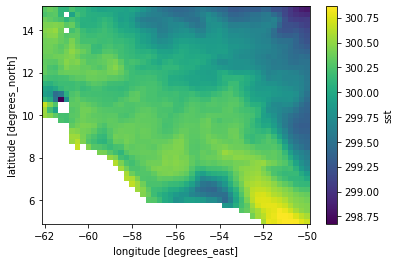

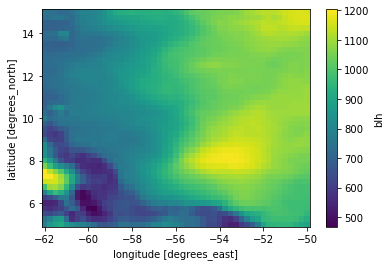

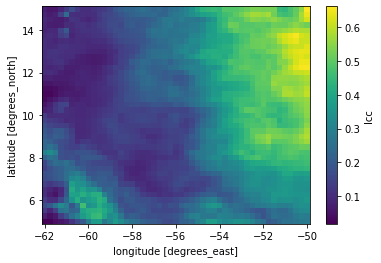

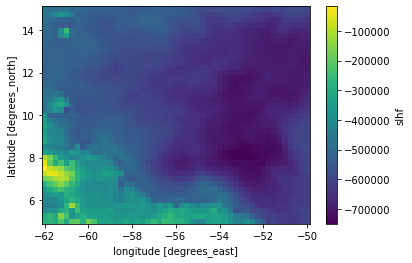

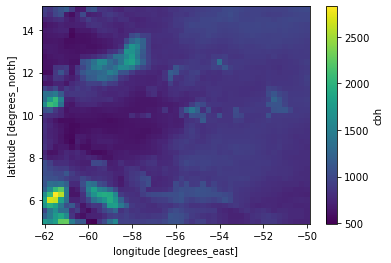

In [3]:
sst_2_3.plot()
plt.show()

blh_2_3.plot()
plt.show()

lcc_2_3.plot()
plt.show()

slhf_2_3.plot()
plt.show()

cbh_2_3.plot()
plt.show()

In [4]:
# Extend the time range for the averages.

sst_1_6 = ds_single['sst'].sel(time=slice('2020-02-01','2020-02-06')).mean(dim='time',skipna='True')
blh_1_6 = ds_single['blh'].sel(time=slice('2020-02-01','2020-02-06')).mean(dim='time',skipna='True')
lcc_1_6 = ds_single['lcc'].sel(time=slice('2020-02-01','2020-02-06')).mean(dim='time',skipna='True')

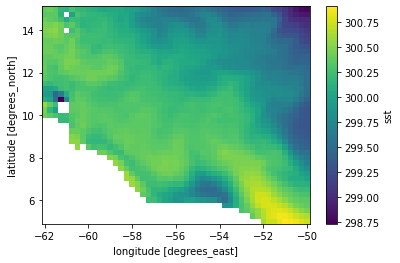

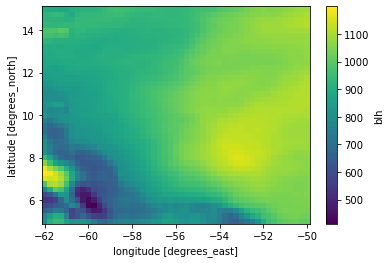

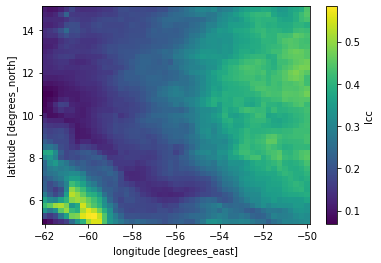

In [5]:
sst_1_6.plot()
plt.show()

blh_1_6.plot()
plt.show()

lcc_1_6.plot()
plt.show()

In [3]:
# Look at a time-height section of some spatially averaged quantities, such as wind speed, temperature and 
# specific humidity. The area of interest is set by the extent variable.

extent = [-55.5,-52,5.5,8.5] # [minlon,maxlon,minlat,maxlat]

def extract_time_height_section(ds,varname,extent):
    field_area = ds[varname].sel(longitude=slice(extent[0],extent[1])).sel(latitude=slice(extent[3],extent[2]))
    sst = ds_single['sst'][0]
    seamask = sst/sst
    field_area = field_area*seamask
    field_ths = field_area.mean(dim='longitude',skipna=True).mean(dim='latitude',skipna=True)
    return field_ths
    
z_tsh = extract_time_height_section(ds_pressure,'z',extent).values/9.81
q_tsh = extract_time_height_section(ds_pressure,'q',extent).values
u_tsh = extract_time_height_section(ds_pressure,'u',extent).values
print(u_tsh.shape)
v_tsh = extract_time_height_section(ds_pressure,'v',extent).values
ws_tsh = np.sqrt(u_tsh**2+v_tsh**2) # wind speed
wd_tsh = 180+180/np.pi*np.arctan2(v_tsh,u_tsh) # counterclockwise from East
#wd_tsh = np.mod((-90-180/np.pi*np.arctan2(v_tsh,u_tsh)),360) # clockwise from North
t_tsh = extract_time_height_section(ds_pressure,'t',extent)

time_tsh = t_tsh.time.values
t_tsh = t_tsh.values

time_tsh_z = np.vstack((time_tsh,time_tsh))

for jj in range(10):
    time_tsh_z = np.vstack((time_tsh_z,time_tsh))

time_tsh_z = np.transpose(time_tsh_z)

(144, 12)


<ipython-input-4-3df29f6e0ceb>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc0 = ax0.pcolor(time_tsh_z,z_tsh,u_tsh)
<ipython-input-4-3df29f6e0ceb>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc1 = ax1.pcolor(time_tsh_z,z_tsh,v_tsh)
<ipython-input-4-3df29f6e0ceb>:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass

(18293.0, 18296.0)

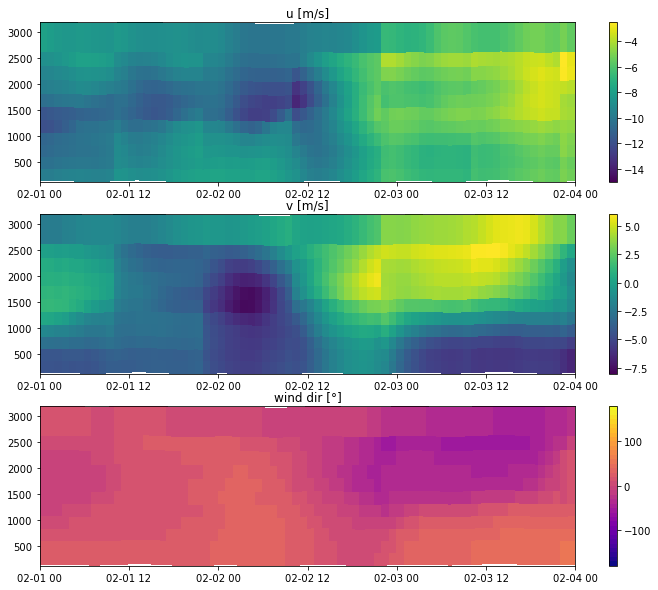

In [4]:
# Check whether the direction is correct.

from matplotlib import cm 
plasma36 = cm.get_cmap('plasma',36)

fig = plt.figure(figsize=(12,10))
ax0 = fig.add_subplot(3, 1, 1)
pc0 = ax0.pcolor(time_tsh_z,z_tsh,u_tsh)
plt.colorbar(pc0)
ax0.set_title('u [m/s]')

ax1 = fig.add_subplot(3, 1, 2)
pc1 = ax1.pcolor(time_tsh_z,z_tsh,v_tsh)
plt.colorbar(pc1)
ax1.set_title('v [m/s]')

wd_tsh[wd_tsh>180] = wd_tsh[wd_tsh>180]-360
ax2 = fig.add_subplot(3, 1, 3)
pc2 = ax2.pcolor(time_tsh_z,z_tsh,wd_tsh,cmap=plasma36,vmin=-180,vmax=180)
plt.colorbar(pc2)
ax2.set_title('wind dir [°]')

ax0.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))
ax1.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))
ax2.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))

<ipython-input-11-5e9624edd67f>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc0 = ax0.pcolor(time_tsh_z,z_tsh,t_tsh-273.15,cmap=inferno16,vmin=8,vmax=24)
<ipython-input-11-5e9624edd67f>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc1 = ax1.pcolor(time_tsh_z,z_tsh,q_tsh*1e3,cmap=vapor16,vmin=0,vmax=16)
<ipython-input-11-5e9624edd67f>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3

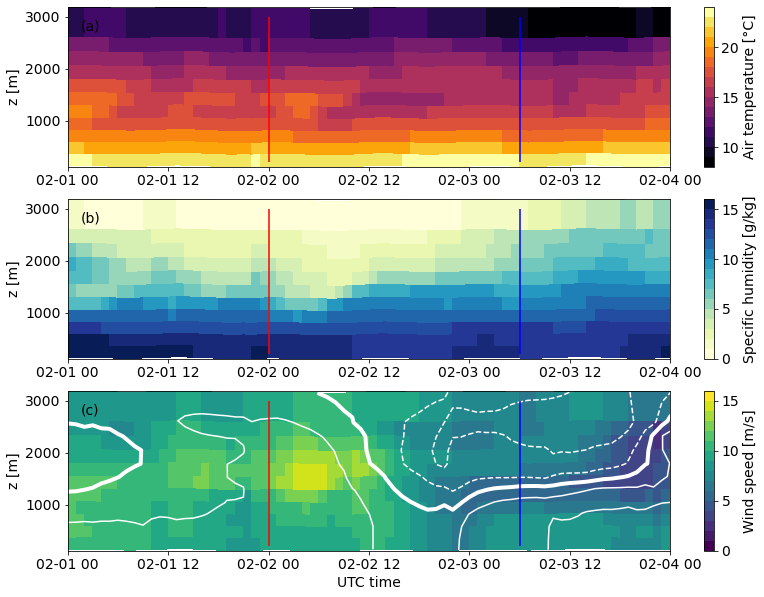

In [11]:
from matplotlib import cm 
inferno16 = cm.get_cmap('inferno',16)
vapor16 = cm.get_cmap('YlGnBu',16)
viridis16 = cm.get_cmap('viridis',16)

from matplotlib.offsetbox import AnchoredText

# Set the values of the wind direction above 180 to be negative.
wd_tsh[wd_tsh>180] = wd_tsh[wd_tsh>180]-360

fig = plt.figure(figsize=(12,10))
ax0 = fig.add_subplot(3, 1, 1)
pc0 = ax0.pcolor(time_tsh_z,z_tsh,t_tsh-273.15,cmap=inferno16,vmin=8,vmax=24)
cb0 = plt.colorbar(pc0,fraction=0.05,aspect=15)
cb0.set_label('Air temperature [°C]',fontsize=14)
cb0.ax.tick_params(labelsize=14)
ax0.set_ylabel('z [m]',fontsize=14)
ax0.tick_params(axis='both', labelsize=14)
ax0.vlines(np.datetime64('2020-02-02T00:00:00'),200,3e3,'r')
ax0.vlines(np.datetime64('2020-02-03T06:00:00'),200,3e3,'b')

ax1 = fig.add_subplot(3, 1, 2)
pc1 = ax1.pcolor(time_tsh_z,z_tsh,q_tsh*1e3,cmap=vapor16,vmin=0,vmax=16)
cb1 = plt.colorbar(pc1,fraction=0.05,aspect=15)
cb1.set_label('Specific humidity [g/kg]',fontsize=14)
cb1.ax.tick_params(labelsize=14)
ax1.set_ylabel('z [m]',fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
ax1.vlines(np.datetime64('2020-02-02T00:00:00'),200,3e3,'r')
ax1.vlines(np.datetime64('2020-02-03T06:00:00'),200,3e3,'b')

ax2 = fig.add_subplot(3, 1, 3)
ax2.contour(time_tsh_z,z_tsh,wd_tsh,levels=np.arange(-40,60,20),colors='w')
ax2.contour(time_tsh_z,z_tsh,wd_tsh,levels=np.arange(0,1),colors='w',linewidths=4)
#ax2.contour(time_tsh_z,z_tsh,wd_tsh-180,levels=np.arange(150,160,10),colors='w')
pc2 = ax2.pcolor(time_tsh_z,z_tsh,ws_tsh,cmap=viridis16,vmin=0,vmax=16)
cb2 = plt.colorbar(pc2,fraction=0.05,aspect=15)
cb2.set_label('Wind speed [m/s]',fontsize=14)
cb2.ax.tick_params(labelsize=14)
ax2.set_xlabel('UTC time',fontsize=14)
ax2.set_ylabel('z [m]',fontsize=14)
ax2.tick_params(axis='both', labelsize=14)
ax2.vlines(np.datetime64('2020-02-02T00:00:00'),200,3e3,'r')
ax2.vlines(np.datetime64('2020-02-03T06:00:00'),200,3e3,'b')

ax0.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))
ax1.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))
ax2.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))

anchored_text0 = AnchoredText('(a)', loc=2, prop=dict(size=14), frameon=False); 
ax0.add_artist(anchored_text0)
anchored_text1 = AnchoredText('(b)', loc=2, prop=dict(size=14), frameon=False); 
ax1.add_artist(anchored_text1)
anchored_text2 = AnchoredText('(c)', loc=2, prop=dict(size=14), frameon=False); 
ax2.add_artist(anchored_text2)

figure_name = 'era5_1-3Feb2020.png'
plt.savefig(figure_name,bbox_inches='tight')

In [15]:
def qsat(t,p):
    """
    usage: es = qsat(t,p)
    Returns saturation vapor pressure es (mb) given t(C) and p(mb).
    After Buck, 1981: J.Appl.Meteor., 20, 1527-1532
    Returns ndarray float for any numeric object input.
    """
    from numpy import copy, asarray, exp

    t2 = copy(asarray(t, dtype=float))  # convert to ndarray float
    p2 = copy(asarray(p, dtype=float))
    es = 6.1121 * exp(17.502 * t2 / (240.97 + t2))
    es = es * (1.0007 + p2 * 3.46e-6)
    return es

def qair(t,p,rh):
    """
    usage: qa, em = qair(t,p,rh)
    Returns specific humidity (g/kg) and partial pressure (mb)
    given t(C), p(mb) and rh(%).
    Returns ndarray float for any numeric object input.
    """
    from numpy import copy, asarray

    rh2 = copy(asarray(rh,dtype=float))  # conversion to ndarray float
    rh2 /= 100.0                         # frational rh
    p2 = copy(asarray(p, dtype=float))
    t2 = copy(asarray(t, dtype=float))
    em = rh2 * qsat(t2,p2)
    qa = 621.97 * em / (p2 - 0.378 * em)
    return (qa, em)


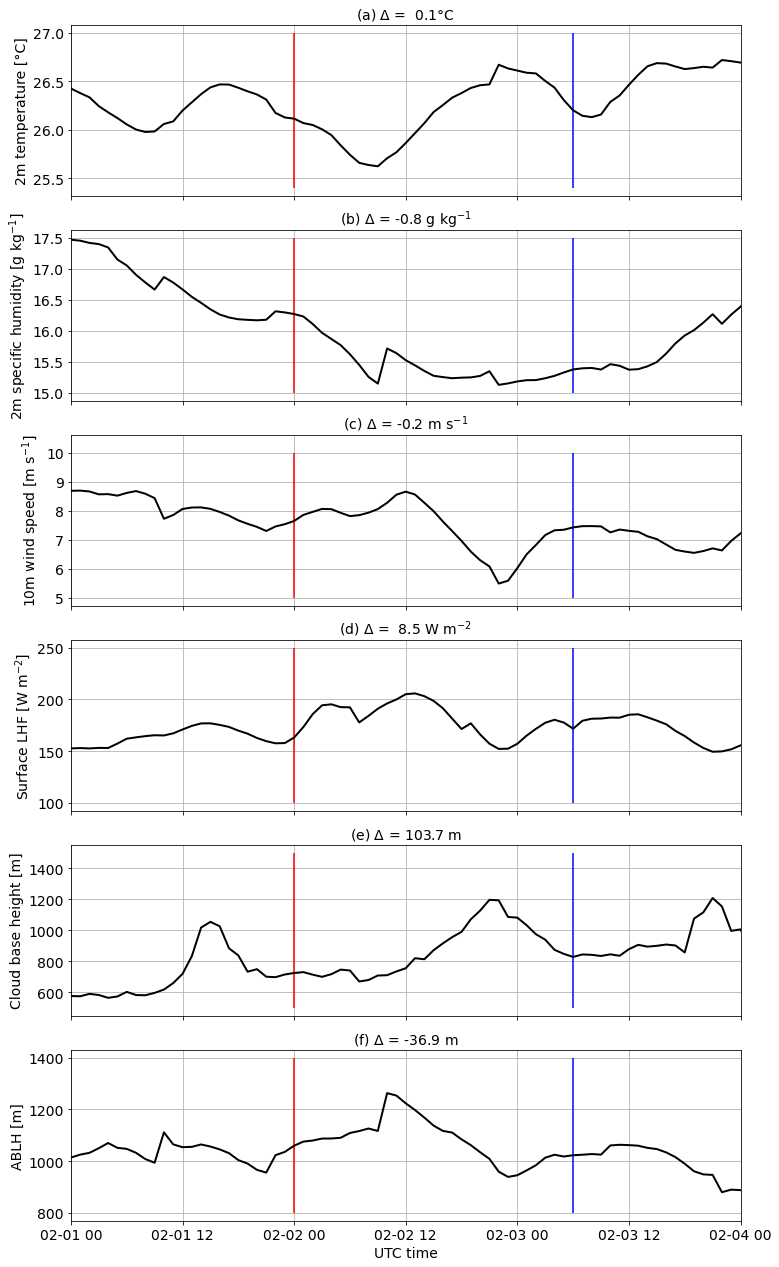

In [21]:
# The function extract_time_height_section can also be used for surface variables.
lhf_ts = extract_time_height_section(ds_single,'slhf',extent)
lhf_ts_cal = -lhf_ts/3600 # the minus is to make it positive upwards and the 3600 is to go from J/m2 to W/m2.
cbh_ts = extract_time_height_section(ds_single,'cbh',extent)
blh_ts = extract_time_height_section(ds_single,'blh',extent)
t2m_ts = extract_time_height_section(ds_single,'t2m',extent)
d2m_ts = extract_time_height_section(ds_single,'d2m',extent)
u10_ts = extract_time_height_section(ds_single,'u10',extent)
v10_ts = extract_time_height_section(ds_single,'v10',extent)
msl_ts = extract_time_height_section(ds_single,'msl',extent)

ww = np.argmin(np.abs(time_tsh-np.datetime64('2020-02-02T00:00:00'))) # time index of the warm point
cc = np.argmin(np.abs(time_tsh-np.datetime64('2020-02-03T06:00:00'))) # time index of the cold point

fig = plt.figure(figsize=(12,22))
ax0 = fig.add_subplot(6, 1, 1)
ax0.plot(time_tsh,t2m_ts-273.15,'k',linewidth=2) 
ax0.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))
ax0.tick_params(axis='both', labelsize=14)
ax0.set_ylabel('2m temperature [°C]',fontsize=14)
ax0.vlines(np.datetime64('2020-02-02T00:00:00'),25.4,27,'r')
ax0.vlines(np.datetime64('2020-02-03T06:00:00'),25.4,27,'b')
delta = t2m_ts[cc].values-t2m_ts[ww].values
ax0.set_title('(a) $\\Delta$ = '+'{:4.1f}'.format(delta) + '°C',fontsize=14)
ax0.xaxis.set_ticklabels([])
plt.grid()

rh_ts = 100-5*(t2m_ts-d2m_ts) # Lawrence, BAMS, 2005, https://doi.org/10.1175/BAMS-86-2-225
q_ts, em_ts = qair(t2m_ts-273.15,msl_ts/100,rh_ts)
ax1 = fig.add_subplot(6, 1, 2)
ax1.plot(time_tsh,q_ts,'k',linewidth=2) 
ax1.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))
ax1.tick_params(axis='both', labelsize=14)
ax1.set_ylabel('2m specific humidity [g kg$^{-1}$]',fontsize=14)
ax1.vlines(np.datetime64('2020-02-02T00:00:00'),15,17.5,'r')
ax1.vlines(np.datetime64('2020-02-03T06:00:00'),15,17.5,'b')
delta = d2m_ts[cc].values-d2m_ts[ww].values
ax1.set_title('(b) $\\Delta$ = '+'{:4.1f}'.format(delta) + ' g kg$^{-1}$',fontsize=14)
ax1.xaxis.set_ticklabels([])
plt.grid()

ws10_ts = np.sqrt(u10_ts**2+v10_ts**2)
ax2 = fig.add_subplot(6, 1, 3)
ax2.plot(time_tsh,ws10_ts,'k',linewidth=2) 
ax2.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))
ax2.tick_params(axis='both', labelsize=14)
ax2.set_ylabel('10m wind speed [m s$^{-1}$]',fontsize=14)
ax2.vlines(np.datetime64('2020-02-02T00:00:00'),5,10,'r')
ax2.vlines(np.datetime64('2020-02-03T06:00:00'),5,10,'b')
delta = ws10_ts[cc].values-ws10_ts[ww].values
ax2.set_title('(c) $\\Delta$ = '+'{:4.1f}'.format(delta) + ' m s$^{-1}$',fontsize=14)
ax2.xaxis.set_ticklabels([])
plt.grid()

ax3 = fig.add_subplot(6, 1, 4)
ax3.plot(time_tsh,lhf_ts_cal,'k',linewidth=2)
ax3.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))
ax3.tick_params(axis='both', labelsize=14)
ax3.set_ylabel('Surface LHF [W m$^{-2}$]',fontsize=14)
ax3.vlines(np.datetime64('2020-02-02T00:00:00'),100,250,'r')
ax3.vlines(np.datetime64('2020-02-03T06:00:00'),100,250,'b')
delta = lhf_ts_cal[cc].values-lhf_ts_cal[ww].values
ax3.set_title('(d) $\\Delta$ = '+'{:4.1f}'.format(delta) + ' W m$^{-2}$',fontsize=14)
ax3.xaxis.set_ticklabels([])
plt.grid()

ax4 = fig.add_subplot(6, 1, 5)
ax4.plot(time_tsh,cbh_ts,'k',linewidth=2)
ax4.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))
ax4.tick_params(axis='both', labelsize=14)
ax4.set_ylabel('Cloud base height [m]',fontsize=14)
ax4.vlines(np.datetime64('2020-02-02T00:00:00'),500,1500,'r')
ax4.vlines(np.datetime64('2020-02-03T06:00:00'),500,1500,'b')
delta = cbh_ts[cc].values-cbh_ts[ww].values
ax4.set_title('(e) $\\Delta$ = '+'{:4.1f}'.format(delta) + ' m',fontsize=14)
ax4.xaxis.set_ticklabels([])
plt.grid()

ax5 = fig.add_subplot(6, 1, 6)
ax5.plot(time_tsh,blh_ts,'k',linewidth=2)
ax5.set_xlim(np.datetime64('2020-02-01'),np.datetime64('2020-02-04'))
ax5.tick_params(axis='both', labelsize=14)
ax5.set_ylabel('ABLH [m]',fontsize=14)
ax5.vlines(np.datetime64('2020-02-02T00:00:00'),800,1400,'r')
ax5.vlines(np.datetime64('2020-02-03T06:00:00'),800,1400,'b')
delta = blh_ts[cc].values-blh_ts[ww].values
ax5.set_title('(f) $\\Delta$ = '+'{:4.1f}'.format(delta) + ' m',fontsize=14)
plt.grid()
ax5.set_xlabel('UTC time',fontsize=14)

figure_name = 'era5_1-3Feb2020_ts.png'
plt.savefig(figure_name,bbox_inches='tight')

In [8]:
ds_single

<xarray.Dataset>
Dimensions:    (latitude: 41, longitude: 49, time: 144)
Coordinates:
  * longitude  (longitude) float32 -62.0 -61.75 -61.5 ... -50.5 -50.25 -50.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... 5.75 5.5 5.25 5.0
  * time       (time) datetime64[ns] 2020-02-01 ... 2020-02-06T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    blh        (time, latitude, longitude) float32 ...
    cbh        (time, latitude, longitude) float32 ...
    lcc        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
    slhf       (time, latitude, longitude) float32 ...
    ssr        (time, latitude, longitude) float32 ...
    sshf       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-06 11:09:03 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [9]:
# Look at the vertical profiles of moisture, temperature and wind in two different locations (on the cold and on
# the warm sides) at two different times:
#    Warm: 2020-02-02T00:00:00, lon=-52.75, lat=8.25
#    Cold: 2020-02-03T06:00:00, lon=54, lat=6.5

lon_warm = -52.75; lat_warm = 8.25 # date_2 = '2020-02-02T00:00:00' on the R/V Atalante trajectory.
#lon_warm = -53; lat_warm = 7.5 # date_2 = '2020-02-02T08:00:00' on the R/V Atalante trajectory.
#lon_cold = -54; lat_cold = 6.5 # date_3 = '2020-02-03T06:00:00' on the R/V Atalante trajectory.
lon_cold = -54.4; lat_cold = 6.5 # date_3 = '2020-02-03T12:00:00' on the R/V Atalante trajectory.

date_2 = '2020-02-02T00:00:00'
#date_2 = '2020-02-02T08:00:00'
date_3 = '2020-02-03T06:00:00'
#date_3 = '2020-02-03T12:00:00'

q_w2 = ds_pressure['q'].sel(time=date_2,longitude=lon_warm,latitude=lat_warm,method='nearest').values
z_w2 = ds_pressure['z'].sel(time=date_2,longitude=lon_warm,latitude=lat_warm,method='nearest').values/9.81
q_c3 = ds_pressure['q'].sel(time=date_3,longitude=lon_cold,latitude=lat_cold,method='nearest').values
z_c3 = ds_pressure['z'].sel(time=date_3,longitude=lon_cold,latitude=lat_cold,method='nearest').values/9.81

blh_w2 = ds_single['blh'].sel(time=date_2,longitude=lon_warm,latitude=lat_warm,method='nearest').values
blh_c3 = ds_single['blh'].sel(time=date_3,longitude=lon_cold,latitude=lat_cold,method='nearest').values

q_w3 = ds_pressure['q'].sel(time=date_3,longitude=lon_warm,latitude=lat_warm,method='nearest').values
z_w3 = ds_pressure['z'].sel(time=date_3,longitude=lon_warm,latitude=lat_warm,method='nearest').values/9.81
q_c2 = ds_pressure['q'].sel(time=date_2,longitude=lon_cold,latitude=lat_cold,method='nearest').values
z_c2 = ds_pressure['z'].sel(time=date_2,longitude=lon_cold,latitude=lat_cold,method='nearest').values/9.81

blh_w3 = ds_single['blh'].sel(time=date_3,longitude=lon_warm,latitude=lat_warm,method='nearest').values
blh_c2 = ds_single['blh'].sel(time=date_2,longitude=lon_cold,latitude=lat_cold,method='nearest').values

2nd Feb: PBLH warm = 1235.9081, PLBH cold = 843.6283
3rd Feb: PBLH warm = 1103.5311, PLBH cold = 990.02405


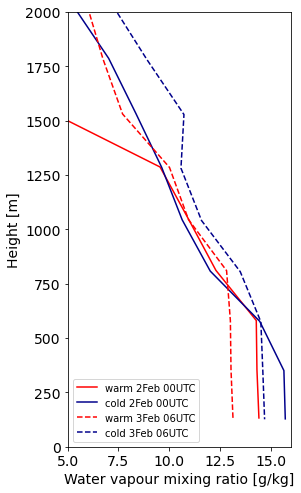

In [11]:
plt.figure(figsize=(4,8))
plt.plot(q_w2*1e3,z_w2,'r')
plt.plot(q_c2*1e3,z_c2,color='darkblue')

plt.plot(q_w3*1e3,z_w3,'r--')
plt.plot(q_c3*1e3,z_c3,'--',color='darkblue')

plt.ylim(0,2e3)
plt.xlim(5,16)
plt.xlabel('Water vapour mixing ratio [g/kg]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=14)

print('2nd Feb: PBLH warm = '+ str(blh_w2)+', PLBH cold = '+ str(blh_c2))
print('3rd Feb: PBLH warm = '+ str(blh_w3)+', PLBH cold = '+ str(blh_c3))

plt.legend(['warm 2Feb 00UTC','cold 2Feb 00UTC', 'warm 3Feb 06UTC', 'cold 3Feb 06UTC'])

In [12]:
# Select an area of 1°x1° around the point of interest to compute the mean and std vertical profile of wvmr.

dlon = 0.5
dlat = 0.5

q_w2_area = ds_pressure['q'].sel(time=date_2,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                 latitude=slice(lat_warm+dlat,lat_warm-dlat))
q_w2_mean = q_w2_area.mean(dim=['longitude','latitude']).values
q_w2_std = q_w2_area.std(dim=['longitude','latitude']).values
z_w2 = ds_pressure['z'].sel(time=date_2,longitude=lon_warm,latitude=lat_warm,method='nearest').values/9.81

q_c3_area = ds_pressure['q'].sel(time=date_3,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                                 latitude=slice(lat_cold+dlat,lat_cold-dlat))
q_c3_mean = q_c3_area.mean(dim=['longitude','latitude']).values
q_c3_std = q_c3_area.std(dim=['longitude','latitude']).values
z_c3 = ds_pressure['z'].sel(time=date_3,longitude=lon_cold,latitude=lat_cold,method='nearest').values/9.81

blh_w2_area = ds_single['blh'].sel(time=date_2,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                   latitude=slice(lat_warm+dlat,lat_warm-dlat))
blh_w2_mean = blh_w2_area.mean(dim=['longitude','latitude']).values
blh_w2_std = blh_w2_area.std(dim=['longitude','latitude']).values

blh_c3_area = ds_single['blh'].sel(time=date_3,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                              latitude=slice(lat_cold+dlat,lat_cold-dlat))
blh_c3_mean = blh_c3_area.mean(dim=['longitude','latitude']).values
blh_c3_std = blh_c3_area.std(dim=['longitude','latitude']).values

q_w3_area = ds_pressure['q'].sel(time=date_3,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                 latitude=slice(lat_warm+dlat,lat_warm-dlat))
q_w3_mean = q_w3_area.mean(dim=['longitude','latitude']).values
q_w3_std = q_w3_area.std(dim=['longitude','latitude']).values
z_w3 = ds_pressure['z'].sel(time=date_3,longitude=lon_warm,latitude=lat_warm,method='nearest').values/9.81

q_c2_area = ds_pressure['q'].sel(time=date_2,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                                 latitude=slice(lat_cold+dlat,lat_cold-dlat))
q_c2_mean = q_c2_area.mean(dim=['longitude','latitude']).values
q_c2_std = q_c2_area.std(dim=['longitude','latitude']).values
z_c2 = ds_pressure['z'].sel(time=date_2,longitude=lon_cold,latitude=lat_cold,method='nearest').values/9.81

blh_w3_area = ds_single['blh'].sel(time=date_3,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                   latitude=slice(lat_warm+dlat,lat_warm-dlat))
blh_w3_mean = blh_w3_area.mean(dim=['longitude','latitude']).values
blh_w3_std = blh_w3_area.std(dim=['longitude','latitude']).values

blh_c2_area = ds_single['blh'].sel(time=date_2,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                              latitude=slice(lat_cold+dlat,lat_cold-dlat))
blh_c2_mean = blh_c2_area.mean(dim=['longitude','latitude']).values
blh_c2_std = blh_c2_area.std(dim=['longitude','latitude']).values

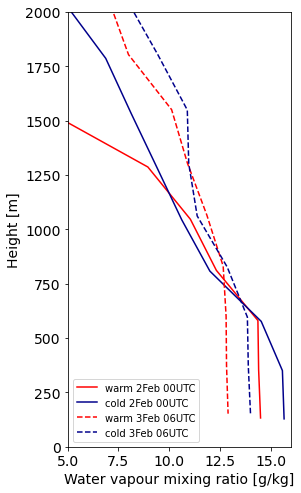

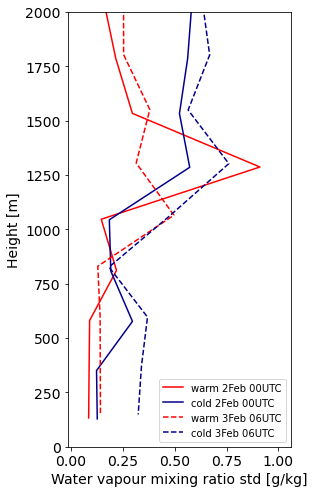

2nd Feb: PBLH warm = 1214.8395 +- 39.74154, PLBH cold = 868.9033 +- 82.423584
3rd Feb: PBLH warm = 1115.3562 +- 21.879019, PLBH cold = 1005.08905 +- 84.652054


In [9]:
plt.figure(figsize=(4,8))
plt.plot(q_w2_mean*1e3,z_w2,'r')
plt.plot(q_c2_mean*1e3,z_c2,color='darkblue')

plt.plot(q_w3_mean*1e3,z_w3,'r--')
plt.plot(q_c3_mean*1e3,z_c3,'--',color='darkblue')

plt.ylim(0,2e3)
plt.xlim(5,16)
plt.xlabel('Water vapour mixing ratio [g/kg]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(['warm 2Feb 00UTC','cold 2Feb 00UTC', 'warm 3Feb 06UTC', 'cold 3Feb 06UTC'])

plt.show()

plt.figure(figsize=(4,8))
plt.plot(q_w2_std*1e3,z_w2,'r')
plt.plot(q_c2_std*1e3,z_c2,color='darkblue')

plt.plot(q_w3_std*1e3,z_w3,'r--')
plt.plot(q_c3_std*1e3,z_c3,'--',color='darkblue')

plt.ylim(0,2e3)
#plt.xlim(5,16)
plt.xlabel('Water vapour mixing ratio std [g/kg]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(['warm 2Feb 00UTC','cold 2Feb 00UTC', 'warm 3Feb 06UTC', 'cold 3Feb 06UTC'])

plt.show()

print('2nd Feb: PBLH warm = '+ str(blh_w2_mean) +' +- '+ str(blh_w2_std) +
      ', PLBH cold = '+ str(blh_c2_mean) +' +- '+ str(blh_c2_std))
print('3rd Feb: PBLH warm = '+ str(blh_w3_mean) +' +- '+ str(blh_w3_std) +
      ', PLBH cold = '+ str(blh_c3_mean) +' +- '+ str(blh_c3_std))

In [13]:
# Now look at the time average over these two days of the vertical profiles of q, together with the PBLH.

dlon = 0.5
dlat = 0.5

q_w_area = ds_pressure['q'].sel(time=slice('2020-02-02','2020-02-03'),longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                latitude=slice(lat_warm+dlat,lat_warm-dlat))
q_w_mean = q_w_area.mean(dim=['time','longitude','latitude']).values
q_w_std = q_w_area.std(dim=['time','longitude','latitude']).values
z_w = ds_pressure['z'].sel(time=date_2,longitude=lon_warm,latitude=lat_warm,method='nearest').values/9.81

q_c_area = ds_pressure['q'].sel(time=slice('2020-02-02','2020-02-03'),longitude=slice(lon_cold-dlon,lon_cold+dlon),
                                latitude=slice(lat_cold+dlat,lat_cold-dlat))
q_c_mean = q_c_area.mean(dim=['time','longitude','latitude']).values
q_c_std = q_c_area.std(dim=['time','longitude','latitude']).values
z_c = ds_pressure['z'].sel(time=date_2,longitude=lon_cold,latitude=lat_cold,method='nearest').values/9.81

blh_w_area = ds_single['blh'].sel(time=slice('2020-02-02','2020-02-03'),longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                  latitude=slice(lat_warm+dlat,lat_warm-dlat))
blh_w_mean = blh_w_area.mean(dim=['time','longitude','latitude']).values
blh_w_std = blh_w_area.std(dim=['time','longitude','latitude']).values

blh_c_area = ds_single['blh'].sel(time=slice('2020-02-02','2020-02-03'),longitude=slice(lon_cold-dlon,lon_cold+dlon),
                              latitude=slice(lat_cold+dlat,lat_cold-dlat))
blh_c_mean = blh_c_area.mean(dim=['time','longitude','latitude']).values
blh_c_std = blh_c_area.std(dim=['time','longitude','latitude']).values

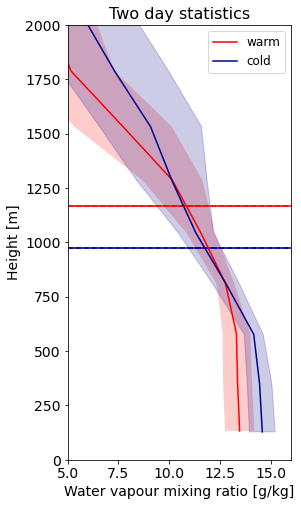

Time average: PBLH warm = 1166.0696 +- 150.21532, PLBH cold = 974.63464 +- 127.896996


In [14]:
plt.figure(figsize=(4,8))
plt.plot(q_w_mean*1e3,z_w,'r')
plt.plot(q_c_mean*1e3,z_c,color='darkblue')

plt.fill(np.append((q_w_mean-q_w_std)*1e3, np.flip((q_w_mean+q_w_std))*1e3),np.append(z_w, np.flip(z_w)),'r',alpha=0.2)
plt.fill(np.append((q_c_mean-q_c_std)*1e3, np.flip((q_c_mean+q_c_std))*1e3),np.append(z_c, np.flip(z_c)),color='darkblue',alpha=0.2)
xmin = 5
xmax = 16

plt.ylim(0,2e3)
plt.xlim(xmin,xmax)
plt.xlabel('Water vapour mixing ratio [g/kg]',fontsize=14)
plt.ylabel('Height [m]',fontsize=14)

plt.hlines(blh_w_mean,xmin,xmax,'r')
plt.hlines(blh_c_mean,xmin,xmax,color='darkblue')
plt.hlines(blh_w_mean,xmin,xmax,linestyles='dashed',color='red')
plt.hlines(blh_c_mean,xmin,xmax,linestyles='dashed',color='darkblue')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(['warm','cold'],fontsize=12)
plt.title('Two day statistics',fontsize=16)

plt.show()

print('Time average: PBLH warm = '+ str(blh_w_mean) +' +- '+ str(blh_w_std) +
      ', PLBH cold = '+ str(blh_c_mean) +' +- '+ str(blh_c_std))

In [29]:
# Function to plot the vertical profile of a variable over the warm and the cold side computing the mean 
# profile (and the std) over a certain area in two instants, specified by the date_2 and date_3 parameters.

def warm_cold_instants_vertical_profiles_area(varname,units,xlabel,date_2,date_2_str,date_3,date_3_str,
                                              lon_warm,lat_warm,lon_cold,lat_cold,dlon,dlat,xmin,xmax,factor=1):

    q_w2_area = ds_pressure[varname].sel(time=date_2,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                         latitude=slice(lat_warm+dlat,lat_warm-dlat))
    q_w2_mean = q_w2_area.mean(dim=['longitude','latitude'],skipna='True').values
    q_w2_std = q_w2_area.std(dim=['longitude','latitude'],skipna='True').values
    z_w2 = ds_pressure['z'].sel(time=date_2,longitude=lon_warm,latitude=lat_warm,method='nearest').values/9.81

    q_c3_area = ds_pressure[varname].sel(time=date_3,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                                         latitude=slice(lat_cold+dlat,lat_cold-dlat))
    q_c3_mean = q_c3_area.mean(dim=['longitude','latitude'],skipna='True').values
    q_c3_std = q_c3_area.std(dim=['longitude','latitude'],skipna='True').values
    z_c3 = ds_pressure['z'].sel(time=date_3,longitude=lon_cold,latitude=lat_cold,method='nearest').values/9.81

    blh_w2_area = ds_single['blh'].sel(time=date_2,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                       latitude=slice(lat_warm+dlat,lat_warm-dlat))
    blh_w2_mean = blh_w2_area.mean(dim=['longitude','latitude'],skipna='True').values
    blh_w2_std = blh_w2_area.std(dim=['longitude','latitude'],skipna='True').values

    blh_c3_area = ds_single['blh'].sel(time=date_3,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                                       latitude=slice(lat_cold+dlat,lat_cold-dlat))
    blh_c3_mean = blh_c3_area.mean(dim=['longitude','latitude'],skipna='True').values
    blh_c3_std = blh_c3_area.std(dim=['longitude','latitude'],skipna='True').values

    q_w3_area = ds_pressure[varname].sel(time=date_3,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                         latitude=slice(lat_warm+dlat,lat_warm-dlat))
    q_w3_mean = q_w3_area.mean(dim=['longitude','latitude'],skipna='True').values
    q_w3_std = q_w3_area.std(dim=['longitude','latitude'],skipna='True').values
    z_w3 = ds_pressure['z'].sel(time=date_3,longitude=lon_warm,latitude=lat_warm,method='nearest').values/9.81

    q_c2_area = ds_pressure[varname].sel(time=date_2,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                                         latitude=slice(lat_cold+dlat,lat_cold-dlat))
    q_c2_mean = q_c2_area.mean(dim=['longitude','latitude'],skipna='True').values
    q_c2_std = q_c2_area.std(dim=['longitude','latitude'],skipna='True').values
    z_c2 = ds_pressure['z'].sel(time=date_2,longitude=lon_cold,latitude=lat_cold,method='nearest').values/9.81

    blh_w3_area = ds_single['blh'].sel(time=date_3,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                       latitude=slice(lat_warm+dlat,lat_warm-dlat))
    blh_w3_mean = blh_w3_area.mean(dim=['longitude','latitude'],skipna='True').values
    blh_w3_std = blh_w3_area.std(dim=['longitude','latitude'],skipna='True').values

    blh_c2_area = ds_single['blh'].sel(time=date_2,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                                  latitude=slice(lat_cold+dlat,lat_cold-dlat))
    blh_c2_mean = blh_c2_area.mean(dim=['longitude','latitude'],skipna='True').values
    blh_c2_std = blh_c2_area.std(dim=['longitude','latitude'],skipna='True').values
    
    plt.figure(figsize=(4,8))
    plt.plot(q_w2_mean*factor,z_w2,'r')
    plt.plot(q_c2_mean*factor,z_c2,color='darkblue')

    plt.plot(q_w3_mean*factor,z_w3,'r--')
    plt.plot(q_c3_mean*factor,z_c3,'--',color='darkblue')
    
    plt.hlines(blh_w2_mean,xmin,xmax,'r')
    plt.hlines(blh_c2_mean,xmin,xmax,color='darkblue')
    plt.hlines(blh_w3_mean,xmin,xmax,linestyles='dashed',color='red')
    plt.hlines(blh_c3_mean,xmin,xmax,linestyles='dashed',color='darkblue')

    plt.ylim(0,2e3)
    plt.xlim(xmin,xmax)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel('Height [m]',fontsize=14)
    plt.grid()

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(['warm '+date_2_str,'cold '+date_2_str, 'warm '+date_3_str, 'cold '+date_3_str],fontsize=12)
    figure_name = 'warm_cold_instants_' + varname + '.png'
    plt.savefig(figure_name,bbox_inches='tight')
    
    # Save the data
    file2save = 'warm_cold_instants_data_' + varname
    d = {'height_w2':np.transpose(z_w2), varname+'_w2_'+units:np.transpose(q_w2_mean*factor), 
         'height_c2':np.transpose(z_c2), varname+'_c2_'+units:np.transpose(q_c2_mean*factor),
         'height_w3':np.transpose(z_w3), varname+'_w3_'+units:np.transpose(q_w3_mean*factor), 
         'height_c3':np.transpose(z_c3), varname+'_c3_'+units:np.transpose(q_c3_mean*factor)}
    df = pd.DataFrame(data=d)
    df.to_csv('./' + file2save + '.txt', index=False)

In [30]:
# Function to plot the vertical profile of a variable over the warm and the cold side computing the mean 
# profile (and the std) over a certain area and over the time frame of interest: date_start, date_end.

def warm_cold_time_avg_vertical_profiles_area(varname,units,xlabel,date_start,date_end,
                                              lon_warm,lat_warm,lon_cold,lat_cold,dlon,dlat,xmin,xmax,factor=1):
    q_w_area = ds_pressure[varname].sel(time=slice(date_start,date_end),longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                    latitude=slice(lat_warm+dlat,lat_warm-dlat))
    q_w_mean = q_w_area.mean(dim=['time','longitude','latitude']).values
    q_w_std = q_w_area.std(dim=['time','longitude','latitude']).values
    z_w = ds_pressure['z'].sel(time=date_2,longitude=lon_warm,latitude=lat_warm,method='nearest').values/9.81

    q_c_area = ds_pressure[varname].sel(time=slice(date_start,date_end),longitude=slice(lon_cold-dlon,lon_cold+dlon),
                                    latitude=slice(lat_cold+dlat,lat_cold-dlat))
    q_c_mean = q_c_area.mean(dim=['time','longitude','latitude']).values
    q_c_std = q_c_area.std(dim=['time','longitude','latitude']).values
    z_c = ds_pressure['z'].sel(time=date_2,longitude=lon_cold,latitude=lat_cold,method='nearest').values/9.81

    blh_w_area = ds_single['blh'].sel(time=slice(date_start,date_end),longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                      latitude=slice(lat_warm+dlat,lat_warm-dlat))
    blh_w_mean = blh_w_area.mean(dim=['time','longitude','latitude']).values
    blh_w_std = blh_w_area.std(dim=['time','longitude','latitude']).values

    blh_c_area = ds_single['blh'].sel(time=slice(date_start,date_end),longitude=slice(lon_cold-dlon,lon_cold+dlon),
                                  latitude=slice(lat_cold+dlat,lat_cold-dlat))
    blh_c_mean = blh_c_area.mean(dim=['time','longitude','latitude']).values
    blh_c_std = blh_c_area.std(dim=['time','longitude','latitude']).values
    
    plt.figure(figsize=(4,8))
    plt.plot(q_w_mean*factor,z_w,'r')
    plt.plot(q_c_mean*factor,z_c,color='darkblue')

    plt.fill(np.append((q_w_mean-q_w_std)*factor, np.flip((q_w_mean+q_w_std))*factor),np.append(z_w, np.flip(z_w)),'r',alpha=0.2)
    plt.fill(np.append((q_c_mean-q_c_std)*factor, np.flip((q_c_mean+q_c_std))*factor),np.append(z_c, np.flip(z_c)),color='darkblue',alpha=0.2)

    plt.ylim(0,2e3)
    plt.xlim(xmin,xmax)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel('Height [m]',fontsize=14)
    plt.grid()

    plt.hlines(blh_w_mean,xmin,xmax,'r')
    plt.hlines(blh_c_mean,xmin,xmax,color='darkblue')
    plt.hlines(blh_w_mean-blh_w_std,xmin,xmax,linestyles='dashed',color='red')
    plt.hlines(blh_w_mean+blh_w_std,xmin,xmax,linestyles='dashed',color='red')
    plt.hlines(blh_c_mean-blh_c_std,xmin,xmax,linestyles='dashed',color='darkblue')
    plt.hlines(blh_c_mean+blh_c_std,xmin,xmax,linestyles='dashed',color='darkblue')

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(['warm','cold'],fontsize=12)
    plt.title('Time statistics',fontsize=16)
    figure_name = 'warm_cold_time_avg_' + varname + '.png'
    plt.savefig(figure_name,bbox_inches='tight')

    # Save the data
    file2save = 'warm_cold_time_avg_data_' + varname
    d = {'height_w':np.transpose(z_w), 'mean_'+varname+'_w_'+units:np.transpose(q_w_mean*factor), 'std_'+varname+'_w_'+units:np.transpose(q_w_std*factor),
         'height_c':np.transpose(z_c), 'mean_'+varname+'_c_'+units:np.transpose(q_c_mean*factor), 'std_'+varname+'_c_'+units:np.transpose(q_c_std*factor)}
    df = pd.DataFrame(data=d)
    df.to_csv('./' + file2save + '.txt', index=False)

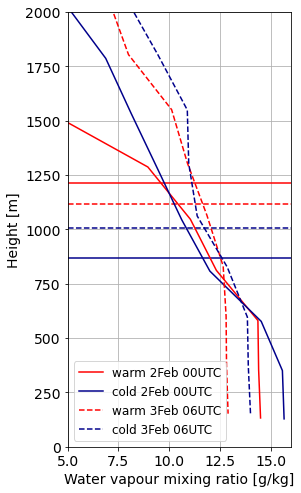

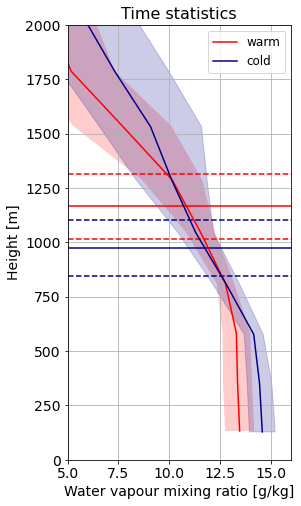

In [52]:
lon_warm = -52.75; lat_warm = 8.25 # date_2 = '2020-02-02T00:00:00' on the R/V Atalante trajectory.
#lon_warm = -53; lat_warm = 7.5 # date_2 = '2020-02-02T08:00:00' on the R/V Atalante trajectory.
#lon_cold = -54; lat_cold = 6.5 # date_3 = '2020-02-03T06:00:00' on the R/V Atalante trajectory.
lon_cold = -54.4; lat_cold = 6.5 # date_3 = '2020-02-03T12:00:00' on the R/V Atalante trajectory.
dlon = 0.5; dlat = 0.5

date_2 = '2020-02-02T00:00:00'; date_2_str = '2Feb 00UTC'
#date_2 = '2020-02-02T08:00:00'
#date_3 = '2020-02-03T06:00:00'
date_3 = '2020-02-03T12:00:00'; date_3_str = '3Feb 06UTC'

date_start = '2020-02-02'
date_end = '2020-02-03'

varname = 'q'; units='g_kg';xlabel = 'Water vapour mixing ratio [g/kg]'; xmin = 5; xmax = 16; factor = 1e3
#varname = 'clwc'; units='g_kg';xlabel = 'Cloud liquid water content [g/kg]'; xmin = 0; xmax = 0.1; factor = 1e3
#varname = 'r'; units='perc'; xlabel = 'Relative humidity [%]'; xmin = 40; xmax = 100; factor = 1
#varname = 'cc'; units='1'; xlabel = 'Fraction of cloud cover [1]'; xmin = 0; xmax = 0.5; factor = 1
#varname = 'w'; xlabel = 'Vertical velocity [Pa/s]'; xmin = -0.2; xmax = 0.2; factor = 1
#varname = 'u'; units='m_s';xlabel = 'Zonal velocity [m/s]'; xmin = -15; xmax = 0; factor = 1
#varname = 'v'; units='m_s'; xlabel = 'Meridional velocity [m/s]'; xmin = -10; xmax = 10; factor = 1
#varname = 't'; units='K'; xlabel = 'Temperature [K]'; xmin = 285; xmax = 300; factor = 1

warm_cold_instants_vertical_profiles_area(varname,units,xlabel,date_2,date_2_str,date_3,date_3_str,lon_warm,lat_warm,lon_cold,lat_cold,dlon,dlat,xmin,xmax,factor)
warm_cold_time_avg_vertical_profiles_area(varname,units,xlabel,date_start,date_end,lon_warm,lat_warm,lon_cold,lat_cold,dlon,dlat,xmin,xmax,factor)

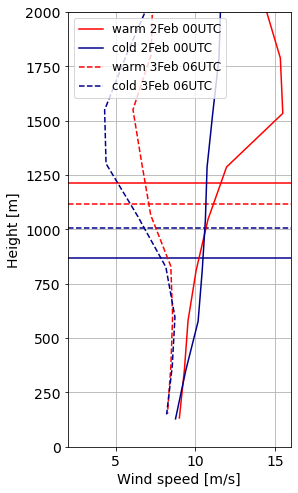

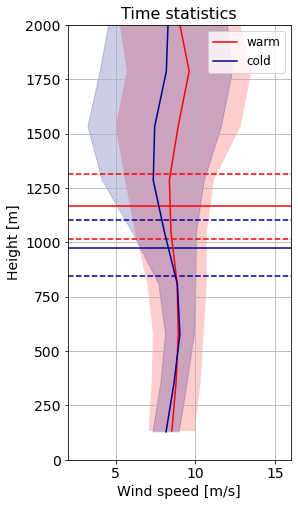

In [70]:
# Compute other fields (e.g. wind velocity, potential temperature) and plot their vertical profiles of interest.

# Wind speed.
field = np.sqrt(ds_pressure['u']**2+ds_pressure['v']**2)
varname = 'wspd'; units='m_s'; xlabel = 'Wind speed [m/s]'; xmin = 2; xmax = 16; factor = 1

# Potential temperature.
#field = ds_pressure['t']*(1000/ds_pressure['level'])**(2/7) # p0 = 1000hPa and the level is the pressure in hPa.
#varname = 'theta'; units='K'; xlabel = 'Potential temperature [K]'; xmin = 295; xmax = 310; factor = 1

# First figure
q_w2_area = field.sel(time=date_2,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                     latitude=slice(lat_warm+dlat,lat_warm-dlat))
q_w2_mean = q_w2_area.mean(dim=['longitude','latitude'],skipna='True').values
q_w2_std = q_w2_area.std(dim=['longitude','latitude'],skipna='True').values
z_w2 = ds_pressure['z'].sel(time=date_2,longitude=lon_warm,latitude=lat_warm,method='nearest').values/9.81

q_c3_area = field.sel(time=date_3,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                     latitude=slice(lat_cold+dlat,lat_cold-dlat))
q_c3_mean = q_c3_area.mean(dim=['longitude','latitude'],skipna='True').values
q_c3_std = q_c3_area.std(dim=['longitude','latitude'],skipna='True').values
z_c3 = ds_pressure['z'].sel(time=date_3,longitude=lon_cold,latitude=lat_cold,method='nearest').values/9.81

blh_w2_area = ds_single['blh'].sel(time=date_2,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                   latitude=slice(lat_warm+dlat,lat_warm-dlat))
blh_w2_mean = blh_w2_area.mean(dim=['longitude','latitude'],skipna='True').values
blh_w2_std = blh_w2_area.std(dim=['longitude','latitude'],skipna='True').values

blh_c3_area = ds_single['blh'].sel(time=date_3,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                                   latitude=slice(lat_cold+dlat,lat_cold-dlat))
blh_c3_mean = blh_c3_area.mean(dim=['longitude','latitude'],skipna='True').values
blh_c3_std = blh_c3_area.std(dim=['longitude','latitude'],skipna='True').values

q_w3_area = field.sel(time=date_3,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                     latitude=slice(lat_warm+dlat,lat_warm-dlat))
q_w3_mean = q_w3_area.mean(dim=['longitude','latitude'],skipna='True').values
q_w3_std = q_w3_area.std(dim=['longitude','latitude'],skipna='True').values
z_w3 = ds_pressure['z'].sel(time=date_3,longitude=lon_warm,latitude=lat_warm,method='nearest').values/9.81

q_c2_area = field.sel(time=date_2,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                     latitude=slice(lat_cold+dlat,lat_cold-dlat))
q_c2_mean = q_c2_area.mean(dim=['longitude','latitude'],skipna='True').values
q_c2_std = q_c2_area.std(dim=['longitude','latitude'],skipna='True').values
z_c2 = ds_pressure['z'].sel(time=date_2,longitude=lon_cold,latitude=lat_cold,method='nearest').values/9.81

blh_w3_area = ds_single['blh'].sel(time=date_3,longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                   latitude=slice(lat_warm+dlat,lat_warm-dlat))
blh_w3_mean = blh_w3_area.mean(dim=['longitude','latitude'],skipna='True').values
blh_w3_std = blh_w3_area.std(dim=['longitude','latitude'],skipna='True').values

blh_c2_area = ds_single['blh'].sel(time=date_2,longitude=slice(lon_cold-dlon,lon_cold+dlon),
                              latitude=slice(lat_cold+dlat,lat_cold-dlat))
blh_c2_mean = blh_c2_area.mean(dim=['longitude','latitude'],skipna='True').values
blh_c2_std = blh_c2_area.std(dim=['longitude','latitude'],skipna='True').values

plt.figure(figsize=(4,8))
plt.plot(q_w2_mean*factor,z_w2,'r')
plt.plot(q_c2_mean*factor,z_c2,color='darkblue')

plt.plot(q_w3_mean*factor,z_w3,'r--')
plt.plot(q_c3_mean*factor,z_c3,'--',color='darkblue')

plt.hlines(blh_w2_mean,xmin,xmax,'r')
plt.hlines(blh_c2_mean,xmin,xmax,color='darkblue')
plt.hlines(blh_w3_mean,xmin,xmax,linestyles='dashed',color='red')
plt.hlines(blh_c3_mean,xmin,xmax,linestyles='dashed',color='darkblue')

plt.ylim(0,2e3)
plt.xlim(xmin,xmax)
plt.xlabel(xlabel,fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.grid()

plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(['warm '+date_2_str,'cold '+date_2_str, 'warm '+date_3_str, 'cold '+date_3_str],fontsize=12)
figure_name = 'warm_cold_instants_' + varname + '.png'
plt.savefig(figure_name,bbox_inches='tight')
plt.show()

file2save = 'warm_cold_instants_data_' + varname
d = {'height_w2':np.transpose(z_w2), varname+'_w2_'+units:np.transpose(q_w2_mean*factor), 
     'height_c2':np.transpose(z_c2), varname+'_c2_'+units:np.transpose(q_c2_mean*factor),
     'height_w3':np.transpose(z_w3), varname+'_w3_'+units:np.transpose(q_w3_mean*factor), 
     'height_c3':np.transpose(z_c3), varname+'_c3_'+units:np.transpose(q_c3_mean*factor)}
df = pd.DataFrame(data=d)
df.to_csv('./' + file2save + '.txt', index=False)

# Second figure
q_w_area = field.sel(time=slice(date_start,date_end),longitude=slice(lon_warm-dlon,lon_warm+dlon),
                    latitude=slice(lat_warm+dlat,lat_warm-dlat))
q_w_mean = q_w_area.mean(dim=['time','longitude','latitude']).values
q_w_std = q_w_area.std(dim=['time','longitude','latitude']).values
z_w = ds_pressure['z'].sel(time=date_2,longitude=lon_warm,latitude=lat_warm,method='nearest').values/9.81

q_c_area = field.sel(time=slice(date_start,date_end),longitude=slice(lon_cold-dlon,lon_cold+dlon),
                    latitude=slice(lat_cold+dlat,lat_cold-dlat))
q_c_mean = q_c_area.mean(dim=['time','longitude','latitude']).values
q_c_std = q_c_area.std(dim=['time','longitude','latitude']).values
z_c = ds_pressure['z'].sel(time=date_2,longitude=lon_cold,latitude=lat_cold,method='nearest').values/9.81

blh_w_area = ds_single['blh'].sel(time=slice(date_start,date_end),longitude=slice(lon_warm-dlon,lon_warm+dlon),
                                  latitude=slice(lat_warm+dlat,lat_warm-dlat))
blh_w_mean = blh_w_area.mean(dim=['time','longitude','latitude']).values
blh_w_std = blh_w_area.std(dim=['time','longitude','latitude']).values

blh_c_area = ds_single['blh'].sel(time=slice(date_start,date_end),longitude=slice(lon_cold-dlon,lon_cold+dlon),
                              latitude=slice(lat_cold+dlat,lat_cold-dlat))
blh_c_mean = blh_c_area.mean(dim=['time','longitude','latitude']).values
blh_c_std = blh_c_area.std(dim=['time','longitude','latitude']).values

plt.figure(figsize=(4,8))
plt.plot(q_w_mean*factor,z_w,'r')
plt.plot(q_c_mean*factor,z_c,color='darkblue')

plt.fill(np.append((q_w_mean-q_w_std)*factor, np.flip((q_w_mean+q_w_std))*factor),np.append(z_w, np.flip(z_w)),'r',alpha=0.2)
plt.fill(np.append((q_c_mean-q_c_std)*factor, np.flip((q_c_mean+q_c_std))*factor),np.append(z_c, np.flip(z_c)),color='darkblue',alpha=0.2)

plt.ylim(0,2e3)
plt.xlim(xmin,xmax)
plt.xlabel(xlabel,fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.grid()

plt.hlines(blh_w_mean,xmin,xmax,'r')
plt.hlines(blh_c_mean,xmin,xmax,color='darkblue')
plt.hlines(blh_w_mean-blh_w_std,xmin,xmax,linestyles='dashed',color='red')
plt.hlines(blh_w_mean+blh_w_std,xmin,xmax,linestyles='dashed',color='red')
plt.hlines(blh_c_mean-blh_c_std,xmin,xmax,linestyles='dashed',color='darkblue')
plt.hlines(blh_c_mean+blh_c_std,xmin,xmax,linestyles='dashed',color='darkblue')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(['warm','cold'],fontsize=12)
plt.title('Time statistics',fontsize=16)
figure_name = 'warm_cold_time_avg_' + varname + '.png'
plt.savefig(figure_name,bbox_inches='tight')
plt.show()

file2save = 'warm_cold_time_avg_data_' + varname
d = {'height_w':np.transpose(z_w), 'mean_'+varname+'_w_'+units:np.transpose(q_w_mean*factor), 'std_'+varname+'_w_'+units:np.transpose(q_w_std*factor),
     'height_c':np.transpose(z_c), 'mean_'+varname+'_c_'+units:np.transpose(q_c_mean*factor), 'std_'+varname+'_c_'+units:np.transpose(q_c_std*factor)}
df = pd.DataFrame(data=d)
df.to_csv('./' + file2save + '.txt', index=False)

In [181]:
# Notes from ERA5 website:
# The boundary layer height calculation is based on the bulk Richardson number (a measure of the atmospheric 
# conditions) following the conclusions of the Seidel et al., JGRA (2012) paper.

In [112]:
# Plot some two day averaged maps.
lon_sst = ds_single['longitude'].values
lat_sst = ds_single['latitude'].values
sst_avg = sst_2_3.values
blh_avg = blh_2_3.values
u10_avg = u10_2_3.values
v10_avg = v10_2_3.values
mask_nan = sst_avg/sst_avg

<ipython-input-113-b1accde5c8e3>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(llon,llat,mask_roi)


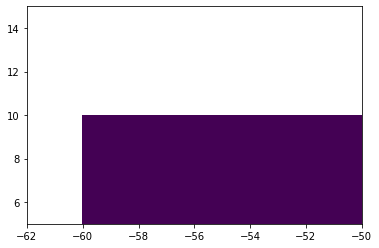

In [113]:
# Define the subregion of interest.
llon, llat = np.meshgrid(lon_sst,lat_sst)
mask_roi = llon/llon
mask_roi[(llon<-60) | (llat>10)] = np.nan
plt.pcolor(llon,llat,mask_roi)

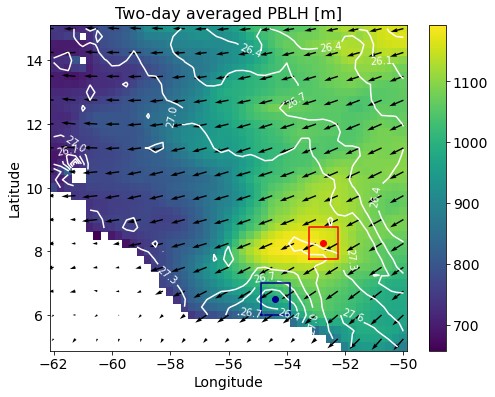

In [206]:
plt.figure(figsize=(8,6))

cs = plt.contour(lon_sst,lat_sst,sst_avg-273.15,colors='w')
plt.clabel(cs)
pc = plt.pcolor(lon_sst,lat_sst,blh_avg*mask_nan,shading='nearest')
step = 3
plt.quiver(lon_sst[::step],lat_sst[::step],u10_avg[::step,::step],v10_avg[::step,::step])
plt.plot([lon_warm-dlon,lon_warm+dlon,lon_warm+dlon,lon_warm-dlon,lon_warm-dlon],
        [lat_warm-dlat,lat_warm-dlat,lat_warm+dlat,lat_warm+dlat,lat_warm-dlat],'r')
plt.plot([lon_cold-dlon,lon_cold+dlon,lon_cold+dlon,lon_cold-dlon,lon_cold-dlon],
        [lat_cold-dlat,lat_cold-dlat,lat_cold+dlat,lat_cold+dlat,lat_cold-dlat],color='darkblue')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Two-day averaged PBLH [m]',fontsize=16)
cbar = plt.colorbar(pc)
cbar.ax.tick_params(labelsize=14) 

plt.plot(lon_warm,lat_warm,'or')
plt.plot(lon_cold,lat_cold,'o',color='darkblue')

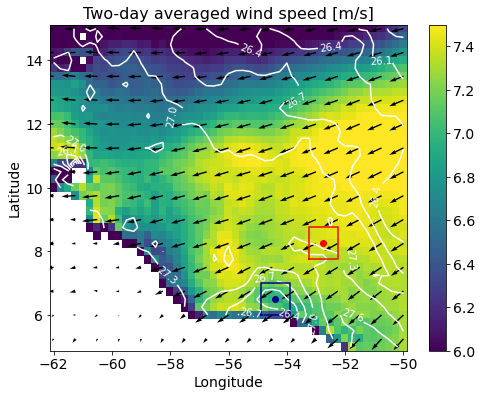

In [207]:
plt.figure(figsize=(8,6))

wspd10_avg = np.sqrt(u10_avg**2+v10_avg**2)
cs = plt.contour(lon_sst,lat_sst,sst_avg-273.15,colors='w')
plt.clabel(cs)
pc = plt.pcolor(lon_sst,lat_sst,wspd10_avg*mask_nan,shading='nearest',vmin=6,vmax=7.5)
step = 3
plt.quiver(lon_sst[::step],lat_sst[::step],u10_avg[::step,::step],v10_avg[::step,::step])

plt.plot([lon_warm-dlon,lon_warm+dlon,lon_warm+dlon,lon_warm-dlon,lon_warm-dlon],
        [lat_warm-dlat,lat_warm-dlat,lat_warm+dlat,lat_warm+dlat,lat_warm-dlat],'r')
plt.plot([lon_cold-dlon,lon_cold+dlon,lon_cold+dlon,lon_cold-dlon,lon_cold-dlon],
        [lat_cold-dlat,lat_cold-dlat,lat_cold+dlat,lat_cold+dlat,lat_cold-dlat],color='darkblue')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.title('Two-day averaged wind speed [m/s]',fontsize=16)
cbar = plt.colorbar(pc)
cbar.ax.tick_params(labelsize=14) 

plt.plot(lon_warm,lat_warm,'or')
plt.plot(lon_cold,lat_cold,'o',color='darkblue')

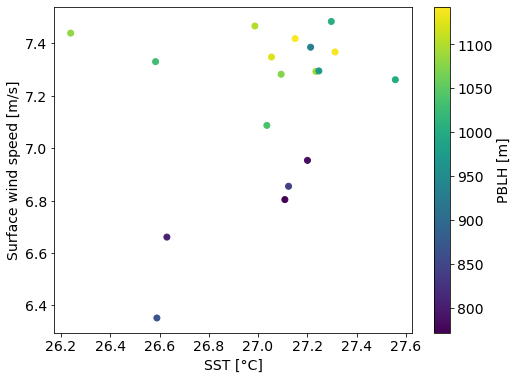

In [133]:
plt.figure(figsize=(8,6))

step = 6
b = wspd10_avg[::step,::step]*mask_nan[::step,::step]*mask_roi[::step,::step]; ylabel='Surface wind speed [m/s]'
c = blh_avg[::step,::step]*mask_nan[::step,::step]*mask_roi[::step,::step]; clabel='PBLH [m]'
a = sst_avg[::step,::step]*mask_roi[::step,::step]-273.15; xlabel='SST [°C]'
sc = plt.scatter(a,b,c=c)

cbar = plt.colorbar(sc)
cbar.set_label(clabel,size=14)
cbar.ax.tick_params(labelsize=14) 

plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

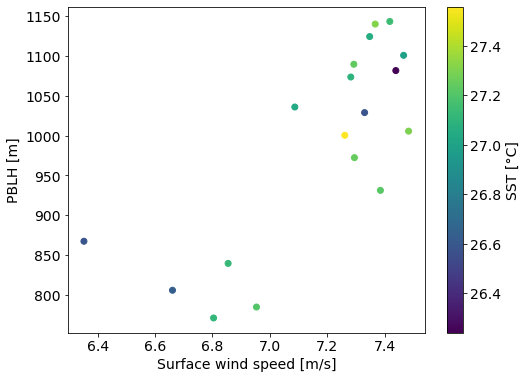

In [134]:
plt.figure(figsize=(8,6))

step = 6
a = wspd10_avg[::step,::step]*mask_nan[::step,::step]*mask_roi[::step,::step]; xlabel='Surface wind speed [m/s]'
b = blh_avg[::step,::step]*mask_nan[::step,::step]*mask_roi[::step,::step]; ylabel='PBLH [m]'
c = sst_avg[::step,::step]*mask_roi[::step,::step]-273.15; clabel='SST [°C]'
sc = plt.scatter(a,b,c=c)

cbar = plt.colorbar(sc)
cbar.set_label(clabel,size=14)
cbar.ax.tick_params(labelsize=14) 

plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

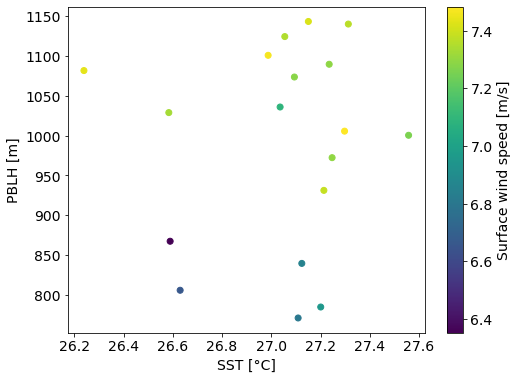

In [135]:
plt.figure(figsize=(8,6))

step = 6
c = wspd10_avg[::step,::step]*mask_nan[::step,::step]*mask_roi[::step,::step]; clabel='Surface wind speed [m/s]'
b = blh_avg[::step,::step]*mask_nan[::step,::step]*mask_roi[::step,::step]; ylabel='PBLH [m]'
a = sst_avg[::step,::step]*mask_roi[::step,::step]-273.15; xlabel='SST [°C]'
sc = plt.scatter(a,b,c=c)

cbar = plt.colorbar(sc)
cbar.set_label(clabel,size=14)
cbar.ax.tick_params(labelsize=14) 

plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

In [61]:
file2read = 'warm_cold_instant_data_' + varname +'.txt'
ndf = pd.read_csv('./' + file2read)


FileNotFoundError: [Errno 2] No such file or directory: './warm_cold_instant_data_theta.txt'

In [65]:

file2read = 'warm_cold_instants_data_' + varname +'.txt'
ndf = pd.read_csv('./' + file2read)
ndf

,height_w2,q_w2_g_kg,height_c2,q_c2_g_kg,height_w3,q_w3_g_kg,height_c3,q_c3_g_kg
0,3166.91330,0.623534,3162.59180,0.968836,3179.21310,1.260355,3176.74370,3.456075
1,2591.14840,2.140477,2588.39400,2.584691,2606.34500,4.994560,2604.73050,6.538335
2,2316.32570,2.736845,2313.57130,3.164595,2331.90200,6.489536,2329.95500,6.916107
3,2048.72140,3.378317,2046.39430,4.807169,2064.25020,6.985968,2062.39840,7.871789
4,1787.86050,3.912625,1786.29350,6.874996,1803.53210,7.996995,1802.15490,9.448680
5,1533.50570,4.181485,1532.69850,8.129939,1550.64950,10.120838,1548.89230,10.894447
6,1286.79690,8.950792,1285.37220,9.392984,1305.17530,10.898468,1302.23100,10.964911
7,1046.49900,11.045996,1043.98200,10.620316,1065.25740,11.859171,1061.69580,11.381367
8,811.23520,12.328316,807.95840,12.007038,830.37354,12.662820,826.66930,12.861340
9,580.76776,14.374145,576.87366,14.536937,600.09600,12.806441,596.43933,13.855261


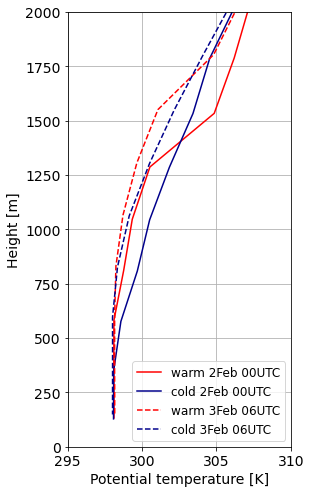

Text(0.5, 1.0, 'Time statistics')

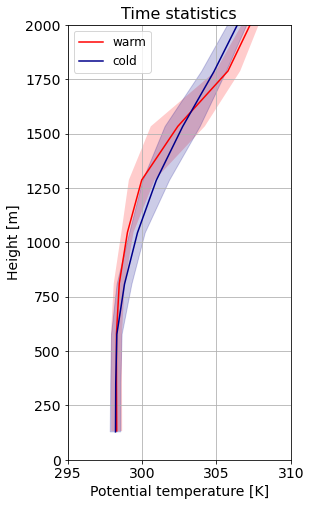

In [73]:
# Piece of code to share to produce the ERA5 figures.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# List of keys to read the files and plot the figures.

# Select the line.
varname = 'q'; units='g_kg';xlabel = 'Water vapour mixing ratio [g/kg]'; xmin = 5; xmax = 16
#varname = 'clwc'; units='g_kg';xlabel = 'Cloud liquid water content [g/kg]'; xmin = 0; xmax = 0.1
#varname = 'r'; units='perc'; xlabel = 'Relative humidity [%]'; xmin = 40; xmax = 100
#varname = 'cc'; units='1'; xlabel = 'Fraction of cloud cover [1]'; xmin = 0; xmax = 0.5
#varname = 'w'; xlabel = 'Vertical velocity [Pa/s]'; xmin = -0.2; xmax = 0.2
#varname = 'u'; units='m_s';xlabel = 'Zonal velocity [m/s]'; xmin = -15; xmax = 0
#varname = 'v'; units='m_s'; xlabel = 'Meridional velocity [m/s]'; xmin = -10; xmax = 10
#varname = 't'; units='K'; xlabel = 'Temperature [K]'; xmin = 285; xmax = 300
varname = 'wspd'; units='m_s'; xlabel = 'Wind speed [m/s]'; xmin = 2; xmax = 16
varname = 'theta'; units='K'; xlabel = 'Potential temperature [K]'; xmin = 295; xmax = 310

# Space and time info.
lon_warm = -52.75; lat_warm = 8.25 # date_2 = '2020-02-02T00:00:00' on the R/V Atalante trajectory.
lon_cold = -54.4; lat_cold = 6.5 # date_3 = '2020-02-03T12:00:00' on the R/V Atalante trajectory.
dlon = 0.5; dlat = 0.5

date_2 = '2020-02-02T00:00:00'; date_2_str = '2Feb 00UTC'
date_3 = '2020-02-03T12:00:00'; date_3_str = '3Feb 06UTC'

date_start = '2020-02-02'
date_end = '2020-02-03'

# Figure 1

file2read = 'warm_cold_instants_data_' + varname +'.txt'
ndf = pd.read_csv('./' + file2read)

mean_w2 = ndf[varname+'_w2_'+units]
mean_c2 = ndf[varname+'_c2_'+units]
mean_w3 = ndf[varname+'_w3_'+units]
mean_c3 = ndf[varname+'_c3_'+units]
z_w2 = ndf['height_w2']
z_c2 = ndf['height_c2']
z_w3 = ndf['height_w3']
z_c3 = ndf['height_c3']
    
plt.figure(figsize=(4,8))
plt.plot(mean_w2,z_w2,'r')
plt.plot(mean_c2,z_c2,color='darkblue')

plt.plot(mean_w3,z_w3,'r--')
plt.plot(mean_c3,z_c3,'--',color='darkblue')

plt.ylim(0,2e3)
plt.xlim(xmin,xmax)
plt.xlabel(xlabel,fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.grid()

plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(['warm '+date_2_str,'cold '+date_2_str, 'warm '+date_3_str, 'cold '+date_3_str],fontsize=12)
plt.show()

# Figure 2

file2read = 'warm_cold_time_avg_data_' + varname +'.txt'
ndf = pd.read_csv('./' + file2read)

mean_w = ndf['mean_'+varname+'_w_'+units]
std_w = ndf['std_'+varname+'_w_'+units]
mean_c = ndf['mean_'+varname+'_c_'+units]
std_c = ndf['std_'+varname+'_c_'+units]
z_w = ndf['height_w']
z_c = ndf['height_c']

plt.figure(figsize=(4,8))
plt.plot(mean_w,z_w,'r')
plt.plot(mean_c,z_c,color='darkblue')

plt.fill(np.append(mean_w-std_w, np.flip(mean_w+std_w)),np.append(z_w, np.flip(z_w)),'r',alpha=0.2)
plt.fill(np.append(mean_c-std_c, np.flip(mean_c+std_c)),np.append(z_c, np.flip(z_c)),color='darkblue',alpha=0.2)

plt.ylim(0,2e3)
plt.xlim(xmin,xmax)
plt.xlabel(xlabel,fontsize=14)
plt.ylabel('Height [m]',fontsize=14)
plt.grid()

plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(['warm','cold'],fontsize=12)
plt.title('Time statistics',fontsize=16)